# Regression with checkup_va as target
- only use one target, no intermediate targets for the LSTM
- try different sequence lengths
- use current va as input (also in sequence modelling part?)

implemented feature quantile normalization (reduces variance that is used to normalize features) and rounding of va values (avoid overfitting to one certain value).
Features are normalized by sum for retina by default.

experiments to run:
- vary sequence length
- evaluate on subset with large change in va -> should do better there if have learned anything!
- try with LSTM - maybe current model structure is suboptimal

Results:
- when training / evaluating on hard subset, models perform a better than the baseline -> have learned something!
- longer sequences are helping (sl2 at least)
- implemented thresholded mse loss to score a deviation of 0.15 from the desired output with loss 0. This seems to work well and performs even better on hard samples (when evaluating with thresholded mae score)
- did not yet try LSTM


In [31]:
import sys
sys.path.append('../')

from estimators import Estimator, merged_config, plot_train_curve_comparison, plot_train_curve
import models
import importlib
import losses
importlib.reload(losses)
from datasets import IOVar, LongitudinalOCTDataset
from sequences import load_sequences_from_pickle, Measurement
import matplotlib.pyplot as plt
import logging
from copy import deepcopy
import os
import matplotlib as mpl
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf

logging.basicConfig(level=logging.INFO) # need one of this?
logging.getLogger().setLevel(logging.INFO) # need one of this?

In [2]:
# load data
workspace_dir = '../../workspace' #'/storage/groups/ml01/workspace/hannah.spitzer/LODE'
fig_dir = 'figures'
features_file = '../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv'
sequences_file = os.path.join(workspace_dir, 'sequences_with_checkup_3_dict.pickle')
sequences_all = load_sequences_from_pickle(sequences_file)
#features_csv = pd.read_csv(features_file, index_col=0)
#features_csv.columns = ['background','epiretinal_membrane','vitrous','camera_effect','neurosensory_retina','intraretinal_fluid','subretinal_fluid','subretinal_hyper_reflective_material','RPE','fibrovascular_PED','dusenoid_PED','posterios_hylaois_membrane','dicom_name','frame','patient_id','oct_path','laterality','study_date']
#features_csv.study_date = pd.to_datetime(features_csv.study_date)

## Fully connected NN concatenating all inputs

In [3]:
default_config = {
    'sequence_data': {
        'load_sequences': False, #True,
        'sequences_fname': sequences_file,
        'features_fname': features_file,
        'num_checkups': 1,
    },
    'sequence_split': {
        'min_len': 3,
        'max_len': None,
        'train_frac': 0.8,
        'val_frac': 0.1,
        'diagnosis': 'AMD',
        'seed': 42
    },
    'model': {
        'model_cls': models.SimpleANNModel,
        'input_vars': [IOVar.CUR_VA, IOVar.INJ_SHORT,IOVar.LENS_SURGERY,IOVar.ALL_FEATURES],
        'output_vars': [IOVar.CHECKUP1_CUR_VA],
        'norm': [None, None, None, None, None],
        'sequence_length': 1,
        'num_dataloaders': 3,
        'model_kwargs': {
            'encoder_layers': {'num_layers':0},
            'dense_layers': {'num_layers': 2},
            'decoder_layers': {'num_layers': 0},
            'output_layer': {'units': 1, 'activation': None}
        },
        'oversample_classification': False,
    },
    'training': {
        'loss': losses.mae_last,
        'metrics': [losses.mae_last],
        'batch_size': 512,
        'epochs': 30,
        'learning_rate': 0.01,
    }
}

### Different sequence lengths (add more information, but keep also short sequences)

In [4]:
# get baseline mae
base_est = Estimator(default_config)
base_est.train_dataset, base_est.val_dataset, base_est.test_dataset = base_est.datasets_from_sequences(sequences_all)
default_val_dataset = LongitudinalOCTDataset(base_est.val_dataset.sequences, 
                                             return_values=[IOVar.CUR_VA, IOVar.CHECKUP1_CUR_VA, IOVar.CHECKUP1_DIFF_VA_CLASS],
                                             norm = base_est.val_dataset.norm, 
                                             sequence_length=base_est.val_dataset.sequence_length,
                                             num_inputs=base_est.val_dataset.num_inputs,
                                             num_parallel_calls=base_est.val_dataset.num_parallel_calls)
baseline_pred, y_true, cls_label = default_val_dataset.get_value_list([IOVar.CUR_VA, IOVar.CHECKUP1_CUR_VA, IOVar.CHECKUP1_DIFF_VA_CLASS], batch_size=512)
cls_label = np.argmax(cls_label[:,-1], axis=-1)

# baseline: predict current va as next va
baseline_mae = losses.mae_last_numpy(y_true, baseline_pred)    

# hard baseline: predict current va as next va - only using hard examples that change a lot
baseline_mae_hard = losses.mae_last_numpy(y_true[cls_label!=2], baseline_pred[cls_label!=2])

# easy baseline: predict mean of all next vas (in train) as next va
mean_y_true_train = np.mean(base_est.train_dataset.get_value_list([IOVar.CHECKUP1_CUR_VA])[0][:,-1,0])
baseline_mae_easy = losses.mae_last_numpy(y_true, np.array([[mean_y_true_train]]))

INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_CUR_VA: 'checkup1_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-p

resulting norm values [None, None, None, None, None]


In [5]:
res_dict_hard = {}
res_dict_all = {}

In [18]:
res_dict_hard['train_all'] = {}
res_dict_all['train_all'] = {}
# train on whole dataset and evaluate on hard subset
for sl in [1,2,3]:
    cur_config = deepcopy(default_config)
    cur_config['model']['sequence_length'] = sl
    est = Estimator(cur_config)
    # only needed to avoid reloading sequences each time
    est.train_dataset, est.val_dataset, est.test_dataset = est.datasets_from_sequences(sequences_all)
    
    # train model
    history = est.train_model(verbose=0)
    y_pred = est.predict_model(est.val_dataset)
    # save mae on hard subset
    res_dict_hard['train_all'][f'sl_{sl}'] = losses.mae_last_numpy(y_true[cls_label!=2], y_pred[cls_label!=2])
    res_dict_all['train_all'][f'sl_{sl}'] = losses.mae_last_numpy(y_true, y_pred)

INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_CUR_VA: 'checkup1_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-p

resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_CUR_VA: 'checkup1_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-p

resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_CUR_VA: 'checkup1_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-p

resulting norm values [None, None, None, None, None]


In [9]:
res_dict_hard['train_hard'] = {}
res_dict_all['train_hard'] = {}
# do the same on the hard samples only  # TODO continue here to see if training on hard only makes a difference!
for sl in [1,2,3]:
    cur_config = deepcopy(default_config)
    cur_config['model']['sequence_length'] = sl
    cur_config['sequence_split']['only_hard_sequences']=True
    est = Estimator(cur_config)
    # only needed to avoid reloading sequences each time
    est.train_dataset, est.val_dataset, est.test_dataset = est.datasets_from_sequences(sequences_all)
    
    # train model
    history = est.train_model(verbose=0)
    # predict on all samples (need to get them first)
    cur_config = deepcopy(default_config)
    cur_config['model']['sequence_length'] = sl
    cur_config['sequence_split']['only_hard_sequences'] = False
    eval_est = Estimator(cur_config)
    eval_est.train_dataset, eval_est.val_dataset, eval_est.test_dataset = eval_est.datasets_from_sequences(sequences_all)
    y_pred = est.predict_model(eval_est.val_dataset)
    
    # save mae on hard subset
    res_dict_hard['train_hard'][f'sl_{sl}'] = losses.mae_last_numpy(y_true[cls_label!=2], y_pred[cls_label!=2])
    res_dict_all['train_hard'][f'sl_{sl}'] = losses.mae_last_numpy(y_true, y_pred)

INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_CUR_VA: 'checkup1_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-p

restricting to only hard sequences!
resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_CUR_VA: 'checkup1_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-p

resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_CUR_VA: 'checkup1_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
INFO:Estimator:Adding features to sequences
100%|██████████| 11152/

restricting to only hard sequences!
resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_CUR_VA: 'checkup1_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-p

resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_CUR_VA: 'checkup1_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
INFO:Estimator:Adding features to sequences
100%|██████████| 11152/

restricting to only hard sequences!
resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP1_CUR_VA: 'checkup1_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Removing 1 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-p

resulting norm values [None, None, None, None, None]


Text(0.5, 1.0, 'evaluation on all')

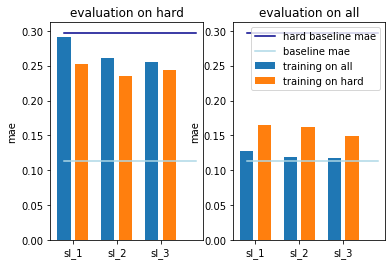

In [22]:
fig, axes = plt.subplots(1,2)
for ax, res_dict in zip(axes, [res_dict_hard, res_dict_all]):
    xs = np.arange(0,len(res_dict['train_all']),1)
    ax.bar(xs, res_dict['train_all'].values(), width=0.3, label='training on all')
    ax.bar(xs+0.4, res_dict['train_hard'].values(), width=0.3, label='training on hard')
    ax.set_xticks(xs+0.2)
    ax.set_xticklabels(res_dict['train_all'].keys())
    ax.plot([0,len(res_dict['train_all'])],[baseline_mae_hard, baseline_mae_hard], color='darkblue', label='hard baseline mae')
    ax.plot([0,len(res_dict['train_all'])],[baseline_mae, baseline_mae], color='lightblue', label='baseline mae')
    ax.set_ylabel('mae')
axes[-1].legend()
axes[0].set_title('evaluation on hard')
axes[1].set_title('evaluation on all')

training on hard sequences improves prediction on hard sequences. On all sequences, the models trained on hard perform worse than the models trained on all. Sequences with length 2/3 slightly improve the results (esp. for training on all)

### Regressing 12 month target

In [32]:
cur_config = deepcopy(default_config)
cur_config['sequence_data']['load_sequences'] = True
cur_config['sequence_data']['sequences_fname'] = os.path.join(workspace_dir, 'sequences_with_checkup_3-12_dict.pickle')
cur_config['sequence_data']['num_checkups'] =  2
cur_config['model']['output_vars'] = [IOVar.CHECKUP2_CUR_VA]

In [33]:
# get baseline mae for 12 month target
est = Estimator(cur_config)
default_val_dataset = LongitudinalOCTDataset(est.val_dataset.sequences, 
                                             return_values=[IOVar.CUR_VA, IOVar.CHECKUP2_CUR_VA, IOVar.CHECKUP2_DIFF_VA_CLASS],
                                             norm = est.val_dataset.norm, 
                                             sequence_length=est.val_dataset.sequence_length,
                                             num_inputs=est.val_dataset.num_inputs,
                                             num_parallel_calls=est.val_dataset.num_parallel_calls)
baseline_pred_12, y_true_12, cls_label_12 = default_val_dataset.get_value_list([IOVar.CUR_VA, IOVar.CHECKUP2_CUR_VA, IOVar.CHECKUP2_DIFF_VA_CLASS], batch_size=512)
cls_label_12 = np.argmax(cls_label_12[:,-1], axis=-1)

# baseline: predict current va as next va
baseline_mae_12 = losses.mae_last_numpy(y_true_12, baseline_pred_12)    

# hard baseline: predict current va as next va - only using hard examples that change a lot
baseline_mae_hard_12 = losses.mae_last_numpy(y_true_12[cls_label_12!=2], baseline_pred_12[cls_label_12!=2])

# easy baseline: predict mean of all next vas (in train) as next va
mean_y_true_train = np.mean(est.train_dataset.get_value_list([IOVar.CHECKUP2_CUR_VA])[0][:,-1,0])
baseline_mae_easy_12 = losses.mae_last_numpy(y_true_12, np.array([[mean_y_true_train]]))

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
INFO:Estimator:Adding features to sequences
 26%|██▌       | 1622/6284 [00:03<00:10, 464.56it/s]


KeyboardInterrupt: 

In [25]:
res_dict_hard['train_all_12'] = {}
res_dict_all['train_all_12'] = {}

for sl in [1,2,3,4,5]:
    cur_config['model']['sequence_length'] = sl
    est = Estimator(cur_config)
    # train model
    history = est.train_model(verbose=0)
    y_pred = est.predict_model(est.val_dataset)
    # save mae on hard subset
    res_dict_hard['train_all_12'][f'sl_{sl}'] = losses.mae_last_numpy(y_true_12[cls_label_12!=2], y_pred[cls_label_12!=2])
    res_dict_all['train_all_12'][f'sl_{sl}'] = losses.mae_last_numpy(y_true_12, y_pred)


INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:13<00:00, 464.87it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)
INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "un

resulting norm values [None, None, None, None, None]


INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:13<00:00, 480.56it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)


resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudin

resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudin

resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudin

resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}


Text(0.5, 1.0, 'evaluation on all')

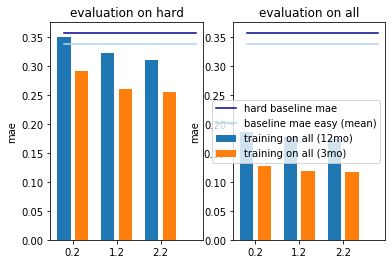

In [30]:
fig, axes = plt.subplots(1,2)
for ax, res_dict in zip(axes, [res_dict_hard, res_dict_all]):
    xs = np.arange(0,len(res_dict['train_all']),1)
    ax.bar(xs, list(res_dict['train_all_12'].values())[:3], width=0.3, label='training on all (12mo)')
    ax.bar(xs+0.4, res_dict['train_all'].values(), width=0.3, label='training on all (3mo)')
    ax.set_xticks(xs+0.2)
    ax.plot([0,len(res_dict['train_all'])],[baseline_mae_hard_12, baseline_mae_hard_12], color='darkblue', label='hard baseline mae')
    ax.plot([0,len(res_dict['train_all'])],[baseline_mae_easy_12, baseline_mae_easy_12], color='lightblue', label='baseline mae easy (mean)')
    ax.set_ylabel('mae')
axes[-1].legend()
axes[0].set_title('evaluation on hard')
axes[1].set_title('evaluation on all')

12 mo task is harder, but at least sl > 1 models can beat prediction of mean baseline

### Train without current VA

In [ ]:
cur_config = deepcopy(default_config)
cur_config['sequence_data']['load_sequences'] = True
cur_config['sequence_data']['sequences_fname'] = os.path.join(workspace_dir, 'sequences_with_checkup_3-12_dict.pickle')
cur_config['sequence_data']['num_checkups'] =  2
cur_config['model']['output_vars'] = [IOVar.CHECKUP1_CUR_VA]
cur_config['input_vars'] = [IOVar.INJ_SHORT,IOVar.LENS_SURGERY,IOVar.ALL_FEATURES]
cur_config['model']['sequence_length'] = 2

est = Estimator(cur_config)
# train model
history = est.train_model(verbose=0)
y_pred = est.predict_model(est.val_dataset)
# save mae on hard subset
res_dict_hard['train_all_12'][f'no_cur_va'] = losses.mae_last_numpy(y_true_12[cls_label_12!=2], y_pred[cls_label_12!=2])
res_dict_all['train_all_12'][f'no_cur_va'] = losses.mae_last_numpy(y_true_12, y_pred)



Text(0.5, 1.0, 'evaluation on all')

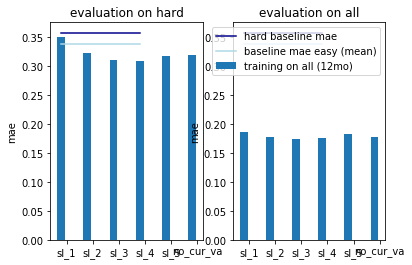

In [35]:
fig, axes = plt.subplots(1,2)
for ax, res_dict in zip(axes, [res_dict_hard, res_dict_all]):
    xs = np.arange(0,len(res_dict['train_all_12']),1)
    ax.bar(xs, list(res_dict['train_all_12'].values()), width=0.3, label='training on all (12mo)')
    #ax.bar(xs+0.4, res_dict['train_all'].values(), width=0.3, label='training on all (3mo)')
    ax.set_xticks(xs+0.2)
    ax.set_xticklabels(res_dict['train_all_12'].keys())
    ax.plot([0,len(res_dict['train_all'])],[baseline_mae_hard_12, baseline_mae_hard_12], color='darkblue', label='hard baseline mae')
    ax.plot([0,len(res_dict['train_all'])],[baseline_mae_easy_12, baseline_mae_easy_12], color='lightblue', label='baseline mae easy (mean)')
    ax.set_ylabel('mae')
axes[-1].legend()
axes[0].set_title('evaluation on hard')
axes[1].set_title('evaluation on all')

[37] of 505 predictions are > than 0.15logMAR


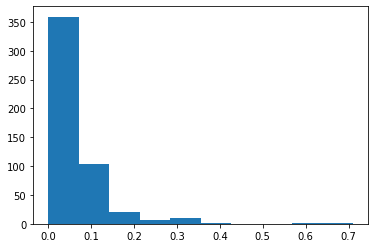

In [36]:
# plot difference between predicted va and current va (are there large differences?)
diff_baseline_pred = np.abs(baseline_pred_12[:,-1] - y_pred[:,-1])
plt.hist(diff_baseline_pred)
print("{} of {} predictions are > than 0.15logMAR".format(sum(diff_baseline_pred>0.15), len(diff_baseline_pred)))

training withouut current va works as well (similar performance for 12 mo forecasting), but overall only few patients have larger differences that 0.15logMAR (noise threshold)

[207] of 505 differences are > than 0.15logMAR


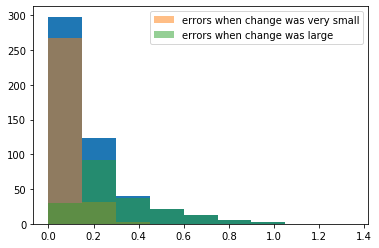

In [46]:
# plot difference between predicted va and true va (are differences mostly < 0.15, the error threshold?)
diff_pred_true = np.abs(y_true_12[:,-1] - y_pred[:,-1])
plt.hist(diff_pred_true, bins=np.arange(0,1.5,0.15))
# also stratify by true difference < 0.15 and >= 0.15
diff_baseline_true = np.abs(y_true_12[:,-1] - baseline_pred_12[:,-1])
plt.hist(diff_pred_true[diff_baseline_true<0.15], label='errors when change was very small', bins=np.arange(0,1.5,0.15), alpha=0.5)
plt.hist(diff_pred_true[diff_baseline_true>=0.15], label='errors when change was large', bins=np.arange(0,1.5,0.15), alpha=0.5)
plt.legend()
print("{} of {} differences are > than 0.15logMAR".format(sum(diff_pred_true>0.15), len(diff_pred_true)))

 about 1/2 of all predictions are > 0.15, and are thus incorrect!

[202] of 505 differences are > than 0.15logMAR


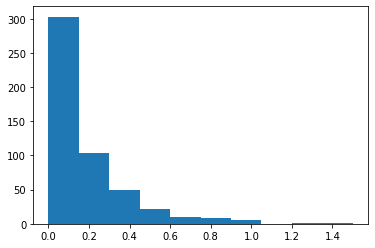

In [40]:
# plot difference between true va and baseline va (are differences mostly < 0.15, the error threshold?)
diff_baseline_pred = np.abs(y_true_12[:,-1] - baseline_pred_12[:,-1])
plt.hist(diff_baseline_pred)
print("{} of {} differences are > than 0.15logMAR".format(sum(diff_baseline_pred>0.15), len(diff_baseline_pred)))

## Other loss function for regression that does not penalize errors < 0.15
- thresholded_mse_last
- also implement thresholded_mae_last metric, which can actually reach 0! 

[0.         0.05555556 0.11111111 0.16666667 0.22222222 0.27777778
 0.33333333 0.38888889 0.44444444 0.5       ]
[0.         0.         0.         0.00027778 0.00521605 0.01632716
 0.03361111 0.0570679  0.08669753 0.1225    ]


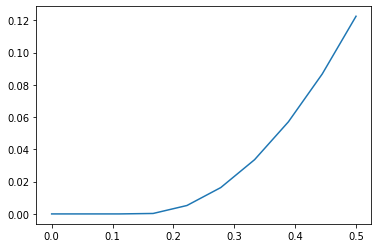

In [4]:
y_true = np.zeros((10))
y_pred = np.linspace(0,0.5,10)
fig, ax = plt.subplots(1,1)
ax.plot(np.abs(y_true - y_pred), losses.thresholded_mse_last(0.15)(y_true, y_pred).numpy())
ax.set_aspect('auto')
print(y_pred)
print(losses.thresholded_mse_last(0.15)(y_true, y_pred).numpy())

In [34]:
cur_config = deepcopy(default_config)
cur_config['sequence_data']['load_sequences'] = True
cur_config['sequence_data']['sequences_fname'] = os.path.join(workspace_dir, 'sequences_with_checkup_3-12_dict.pickle')
cur_config['sequence_data']['num_checkups'] =  2
cur_config['model']['output_vars'] = [IOVar.CHECKUP2_CUR_VA]
cur_config['training']['loss'] = losses.thresholded_mse_last(0.15)
cur_config['training']['metrics'] = [losses.thresholded_mae_last(0.15)]
cur_config['model']['sequence_length'] = 2

In [35]:
# get baseline mae for 12 month target
est = Estimator(cur_config)
default_val_dataset = LongitudinalOCTDataset(est.val_dataset.sequences, 
                                             return_values=[IOVar.CUR_VA, IOVar.CHECKUP2_CUR_VA, IOVar.CHECKUP2_DIFF_VA_CLASS],
                                             norm = est.val_dataset.norm, 
                                             sequence_length=est.val_dataset.sequence_length,
                                             num_inputs=est.val_dataset.num_inputs,
                                             num_parallel_calls=est.val_dataset.num_parallel_calls)
baseline_pred_12, y_true_12, cls_label_12 = default_val_dataset.get_value_list([IOVar.CUR_VA, IOVar.CHECKUP2_CUR_VA, IOVar.CHECKUP2_DIFF_VA_CLASS], batch_size=512)
cls_label_12 = np.argmax(cls_label_12[:,-1], axis=-1)

# baseline: predict current va as next va
baseline_mae_12 = losses.thresholded_mae_last_numpy(y_true_12, baseline_pred_12)    

# hard baseline: predict current va as next va - only using hard examples that change a lot
baseline_mae_hard_12 = losses.thresholded_mae_last_numpy(y_true_12[cls_label_12!=2], baseline_pred_12[cls_label_12!=2])

# easy baseline: predict mean of all next vas (in train) as next va
mean_y_true_train = np.mean(est.train_dataset.get_value_list([IOVar.CHECKUP2_CUR_VA])[0][:,-1,0])
baseline_mae_easy_12 = losses.thresholded_mae_last_numpy(y_true_12, np.array([[mean_y_true_train]]))

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:12<00:00, 502.35it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)


resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}


In [40]:
# compare different loss functions
res_dict = {'hard':{},'all':{}}
for name, loss in [('thresholded_mse', losses.thresholded_mse_last(0.15)), ('thresholded_mae', losses.thresholded_mae_last(0.15)), 
                   ('mae', losses.mae_last), ('mse', losses.mse_last)]:
    cur_config['training']['loss'] = loss
    est = Estimator(cur_config)
    # train model
    history = est.train_model(verbose=1)
    y_pred = est.predict_model(est.val_dataset)
    res_dict['hard'][name] = losses.thresholded_mae_last_numpy(y_true_12[cls_label_12!=2], y_pred[cls_label_12!=2])
    res_dict['all'][name] = losses.thresholded_mae_last_numpy(y_true_12, y_pred)

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:12<00:00, 502.11it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)


resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}


Epoch 1/30
8/8 [==============================] - 1s 120ms/step - loss: 0.3575 - thresholded_mae_last_fn: 0.4529 - val_loss: 0.1383 - val_thresholded_mae_last_fn: 0.2184
Epoch 2/30
8/8 [==============================] - 1s 64ms/step - loss: 0.0591 - thresholded_mae_last_fn: 0.1501 - val_loss: 0.0520 - val_thresholded_mae_last_fn: 0.1133
Epoch 3/30
8/8 [==============================] - 0s 61ms/step - loss: 0.0323 - thresholded_mae_last_fn: 0.0896 - val_loss: 0.0403 - val_thresholded_mae_last_fn: 0.1285
Epoch 4/30
8/8 [==============================] - 0s 62ms/step - loss: 0.0249 - thresholded_mae_last_fn: 0.0798 - val_loss: 0.0346 - val_thresholded_mae_last_fn: 0.0829
Epoch 5/30
8/8 [==============================] - 0s 62ms/step - loss: 0.0204 - thresholded_mae_last_fn: 0.0594 - val_loss: 0.0300 - val_thresholded_mae_last_fn: 0.0784
Epoch 6/30
8/8 [==============================] - 0s 61ms/step - loss: 0.0194 - thresholded_mae_last_fn: 0.0536 - val_loss: 0.0292 - val_thresholded_mae_l

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:12<00:00, 490.85it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)


resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}


Epoch 1/30
8/8 [==============================] - 1s 100ms/step - loss: 0.4284 - thresholded_mae_last_fn: 0.4503 - val_loss: 0.2279 - val_thresholded_mae_last_fn: 0.2279
Epoch 2/30
8/8 [==============================] - 0s 61ms/step - loss: 0.1844 - thresholded_mae_last_fn: 0.1875 - val_loss: 0.0966 - val_thresholded_mae_last_fn: 0.0966
Epoch 3/30
8/8 [==============================] - 1s 70ms/step - loss: 0.0868 - thresholded_mae_last_fn: 0.0879 - val_loss: 0.0830 - val_thresholded_mae_last_fn: 0.0830
Epoch 4/30
8/8 [==============================] - 0s 59ms/step - loss: 0.0656 - thresholded_mae_last_fn: 0.0655 - val_loss: 0.0763 - val_thresholded_mae_last_fn: 0.0763
Epoch 5/30
8/8 [==============================] - 0s 59ms/step - loss: 0.0560 - thresholded_mae_last_fn: 0.0551 - val_loss: 0.0757 - val_thresholded_mae_last_fn: 0.0757
Epoch 6/30
8/8 [==============================] - 0s 59ms/step - loss: 0.0518 - thresholded_mae_last_fn: 0.0508 - val_loss: 0.0744 - val_thresholded_mae_l

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:14<00:00, 437.86it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)


resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}


Epoch 1/30
8/8 [==============================] - 1s 97ms/step - loss: 0.3754 - thresholded_mae_last_fn: 0.2578 - val_loss: 0.2298 - val_thresholded_mae_last_fn: 0.1171
Epoch 2/30
8/8 [==============================] - 1s 63ms/step - loss: 0.1956 - thresholded_mae_last_fn: 0.0849 - val_loss: 0.1797 - val_thresholded_mae_last_fn: 0.0757
Epoch 3/30
8/8 [==============================] - 1s 65ms/step - loss: 0.1578 - thresholded_mae_last_fn: 0.0567 - val_loss: 0.1816 - val_thresholded_mae_last_fn: 0.0789
Epoch 4/30
8/8 [==============================] - 1s 64ms/step - loss: 0.1551 - thresholded_mae_last_fn: 0.0560 - val_loss: 0.1846 - val_thresholded_mae_last_fn: 0.0818
Epoch 5/30
8/8 [==============================] - 1s 64ms/step - loss: 0.1500 - thresholded_mae_last_fn: 0.0522 - val_loss: 0.1852 - val_thresholded_mae_last_fn: 0.0799
Epoch 6/30
8/8 [==============================] - 1s 67ms/step - loss: 0.1445 - thresholded_mae_last_fn: 0.0498 - val_loss: 0.1800 - val_thresholded_mae_la

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:12<00:00, 490.47it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)


resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}


Epoch 1/30
8/8 [==============================] - 1s 92ms/step - loss: 0.4840 - thresholded_mae_last_fn: 0.4315 - val_loss: 0.1181 - val_thresholded_mae_last_fn: 0.1465
Epoch 2/30
8/8 [==============================] - 1s 67ms/step - loss: 0.1270 - thresholded_mae_last_fn: 0.1590 - val_loss: 0.1231 - val_thresholded_mae_last_fn: 0.1379
Epoch 3/30
8/8 [==============================] - 1s 64ms/step - loss: 0.0739 - thresholded_mae_last_fn: 0.0936 - val_loss: 0.0738 - val_thresholded_mae_last_fn: 0.0833
Epoch 4/30
8/8 [==============================] - 0s 60ms/step - loss: 0.0571 - thresholded_mae_last_fn: 0.0645 - val_loss: 0.0642 - val_thresholded_mae_last_fn: 0.0788
Epoch 5/30
8/8 [==============================] - 0s 60ms/step - loss: 0.0513 - thresholded_mae_last_fn: 0.0567 - val_loss: 0.0616 - val_thresholded_mae_last_fn: 0.0736
Epoch 6/30
8/8 [==============================] - 0s 59ms/step - loss: 0.0494 - thresholded_mae_last_fn: 0.0543 - val_loss: 0.0635 - val_thresholded_mae_la

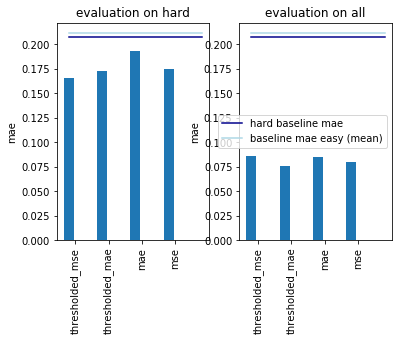

In [41]:
fig, axes = plt.subplots(1,2)
for ax, key in zip(axes, ['hard', 'all']):
    xs = np.arange(0,len(res_dict[key].values()),1)
    ax.bar(xs, list(res_dict[key].values()), width=0.3)
    ax.set_title('evaluation on {}'.format(key))
    #ax.bar(xs+0.4, res_dict['train_all'].values(), width=0.3, label='training on all (3mo)')
    ax.set_xticks(xs+0.2)
    ax.set_xticklabels(res_dict[key].keys(), rotation=90)
    ax.plot([0,len(res_dict[key])],[baseline_mae_hard_12, baseline_mae_hard_12], color='darkblue', label='hard baseline mae')
    ax.plot([0,len(res_dict[key])],[baseline_mae_easy_12, baseline_mae_easy_12], color='lightblue', label='baseline mae easy (mean)')
    ax.set_ylabel('mae')
axes[-1].legend()


thresholded mse performs best on hard samples -> use this loss fn from now on - the hope is that with this loss will actually have to learn sth about the difficult samples

In [16]:
print(losses.thresholded_mae_last_numpy(y_true_12[cls_label_12!=2], y_pred[cls_label_12!=2]))
print(losses.thresholded_mae_last_numpy(y_true_12, y_pred))




0.26729586583626747
0.1901429523468608


[271] of 505 differences are > than 0.15logMAR


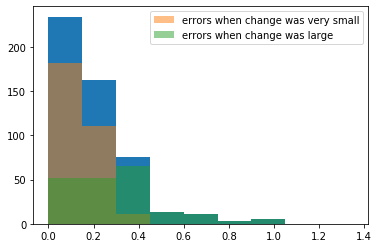

In [11]:
# plot difference between predicted va and true va (are differences mostly < 0.15, the error threshold?)
diff_pred_true = np.abs(y_true_12[:,-1] - y_pred[:,-1])
plt.hist(diff_pred_true, bins=np.arange(0,1.5,0.15))
# also stratify by true difference < 0.15 and >= 0.15
diff_baseline_true = np.abs(y_true_12[:,-1] - baseline_pred_12[:,-1])
plt.hist(diff_pred_true[diff_baseline_true<0.15], label='errors when change was very small', bins=np.arange(0,1.5,0.15), alpha=0.5)
plt.hist(diff_pred_true[diff_baseline_true>=0.15], label='errors when change was large', bins=np.arange(0,1.5,0.15), alpha=0.5)
plt.legend()
print("{} of {} differences are > than 0.15logMAR".format(sum(diff_pred_true>0.15), len(diff_pred_true)))

[171] of 505 predictions are > than 0.15logMAR


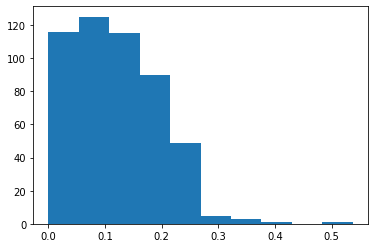

In [12]:
# plot difference between predicted va and current va (are there large differences?)
diff_baseline_pred = np.abs(baseline_pred_12[:,-1] - y_pred[:,-1])
plt.hist(diff_baseline_pred)
print("{} of {} predictions are > than 0.15logMAR".format(sum(diff_baseline_pred>0.15), len(diff_baseline_pred)))

In [19]:
diff_pred_true.shape

(505, 1)

In [15]:
plt.hist2d

<function matplotlib.pyplot.hist2d(x, y, bins=10, range=None, density=False, weights=None, cmin=None, cmax=None, *, data=None, **kwargs)>

(array([[65., 26., 16.,  2.,  2.,  0.,  4.,  0.,  0.,  1.],
        [66., 27., 22.,  4.,  4.,  2.,  0.,  0.,  0.,  0.],
        [56., 38., 15.,  4.,  1.,  0.,  1.,  0.,  0.,  0.],
        [33., 42., 11.,  1.,  3.,  0.,  0.,  0.,  0.,  0.],
        [10., 26.,  8.,  3.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([1.71303749e-04, 5.38966060e-02, 1.07621908e-01, 1.61347210e-01,
        2.15072513e-01, 2.68797815e-01, 3.22523117e-01, 3.76248419e-01,
        4.29973722e-01, 4.83699024e-01, 5.37424326e-01]),
 array([6.91175461e-04, 1.48544389e-01, 2.96397603e-01, 4.44250816e-01,
        5.92104030e-01, 7.39957243e-01, 8.87810457e-01, 1.03566367e+00,
        1.18351688e+00, 1.33137010e+00, 1.47922331e+

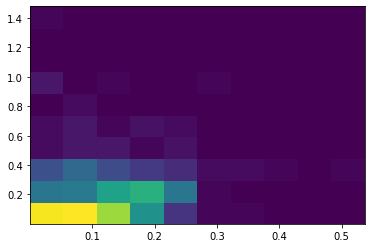

In [21]:
plt.hist2d(diff_baseline_pred[:,0], diff_pred_true[:,0])